In [1]:
%matplotlib notebook
import random
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
class GeneticAlgorithm:
    
    def __init__(self, n_cities, n_paths, mutation_probability):
        self.n_cities = n_cities
        self.n_paths = n_paths
        self.mutation_probability = mutation_probability
        #set up initial population matrix n_paths*(n_cities-1) since we start from city 0
        self.population = np.outer(np.ones(n_paths), np.arange(1,n_cities))
        #create the fist population by random permutation 
        self.population = np.apply_along_axis(np.random.permutation, 1, self.population)
        
    def distance (self,x1, y1, x2, y2):
        return math.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    def build_child(self,v1,v2):
        intersection = np.intersect1d(v1,v2)
        all_cities = np.arange(1,self.n_cities)
        # check if v1 and v2 have cities in common
        if (len(intersection) > 0):
            diff = np.setdiff1d(v1, intersection)
            # remove the cities from v1
            v1 = [o for o in v1 if o in diff]
        excluded = np.concatenate((v1,v2))
        third = np.setdiff1d(all_cities, excluded)
        return np.concatenate((v1,third,v2))
        
    def set_cities(self):
        self.x_coord = np.random.uniform(0,100,self.n_cities)
        self.y_coord = np.random.uniform(10,30,self.n_cities)
        self.distances = np.zeros((self.n_cities,self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                self.distances[i,j] = self.distance( self.x_coord[i],  self.y_coord[i],  self.x_coord[j],  self.y_coord[j])
     
    def initialize_cities(self,x_coord,y_coord):
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.distances = np.zeros((self.n_cities,self.n_cities))
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                self.distances[i,j] = self.distance( self.x_coord[i],  self.y_coord[i],  self.x_coord[j],  self.y_coord[j])
     
    def compute_fitness(self):
        # returns indices ordered by their fitness value
        fit_values = np.ones(self.n_paths)
        pos = 0
        for path in self.population:
            l = 0
            for i in range(self.n_cities-2):
                l = l + self.distances[int(path[i]),int(path[i+1])]
            #compute the distance from the starting city(0) to the first city in the path
            l = l + self.distances[0,int(path[0])]
            #compute the distance from the last city in the path to city 0
            l = l + self.distances[int(path[self.n_cities-2]),0]
            fit_values[pos] = l  
            pos = pos + 1
        return np.argsort(fit_values)
    
    #selection function
    def selection(self):
        indices = self.compute_fitness()
        #select at most half of the paths
        if self.n_paths//2 > 2:
            p = np.random.randint(2,self.n_paths//2,1)
        else:
             p = np.random.randint(2,self.n_paths,1)
        i = 0
        #select the p fittest paths
        self.fittest_parents = np.outer(np.ones(p), np.arange(1,self.n_cities))
        while(i < p):
            self.fittest_parents[i] = self.population[indices[i]]
            i = i+1

    #produce the childs by crossbreeding the p fittest parents
    #the number of paths is the same
    def crossbreeding(self):
        n_parents = len(self.fittest_parents)
        for i in range(self.n_paths-1):
            #select the indices of the two parents
            parent1 = np.random.randint(0,n_parents,1)[0]
            parent2 = np.random.randint(0,n_parents,1)[0]
            if (parent1 != parent2) :
                #select where to split the parents
                pos1 = np.random.randint(1,self.n_cities-1,1)[0]
                pos2 = np.random.randint(1,self.n_cities-1,1)[0]
                # select the parents
                parent1 = self.fittest_parents[parent1]
                parent2 = self.fittest_parents[parent2]
                # build the children
                self.population[i] = self.build_child(parent1[0:pos1], parent2[pos2:])
                self.population[i+1] = self.build_child(parent1[pos2:], parent2[0:pos1])
        
    # random mutation in the path           
    def mutate(self):
        # mutate only in few cases
        for i in range(self.n_paths):
            p = np.random.uniform(0,1,1)[0]
            if (p < self.mutation_probability):
                # swap toe cities randomly
                path = self.population[i]
                pos1 = np.random.randint(0,self.n_cities-1,1)[0]
                pos2 = np.random.randint(0,self.n_cities-1,1)[0]
                path[[pos1, pos2]] = path[[pos2, pos1]]
                self.population[i] = path
    
    #generates a new generation of paths
    def evolve(self):
        self.selection()
        self.crossbreeding()
        self.mutate()
    
    # returns the best fitness value of the current generation
    def best_distance(self):
        fit_values = np.ones(self.n_paths)
        pos = 0
        for path in self.population:
            l = 0
            for i in range(self.n_cities-2):
                l = l + self.distances[int(path[i]),int(path[i+1])]
            l = l + self.distances[0,int(path[0])]
            l = l + self.distances[int(path[self.n_cities-2]),0]
            fit_values[pos] = l  
            pos = pos + 1
        return np.min(fit_values)
    
    # returns the mean fitness value of the current generation
    def mean_distance(self):
        fit_values = np.ones(self.n_paths)
        pos = 0
        for path in self.population:
            l = 0
            for i in range(self.n_cities-2):
                l = l + self.distances[int(path[i]),int(path[i+1])]
            l = l + self.distances[0,int(path[0])]
            l = l + self.distances[int(path[self.n_cities-2]),0]
            fit_values[pos] = l  
            pos = pos + 1
        return np.min(fit_values)
    
    def best_path(self):
        fit_values = np.ones(self.n_paths)
        pos = 0
        for path in self.population:
            l = 0
            for i in range(self.n_cities-2):
                l = l + self.distances[int(path[i]),int(path[i+1])]
            l = l + self.distances[0,int(path[0])]
            l = l + self.distances[int(path[self.n_cities-2]),0]
            fit_values[pos] = l  
            pos = pos + 1
        index_best_path = np.argmin(fit_values)
        return self.population[index_best_path]

In [3]:
# metropolis algorithm, tells whether or not to use the new state produced by the evolution
def acceptance(cost_starting_state, cost_new_state, beta):
    if cost_new_state <= cost_starting_state:
        return True
    else:
        threshold = np.random.uniform(0,1,1)[0]
        p = np.exp(- (cost_new_state - cost_starting_state)*beta)
        return np.min(np.array([1,p])) > threshold

In [4]:
#read the position of the cities
with open('x.pickle', 'rb') as handle:
    x_coord = pickle.load(handle)
with open('y.pickle', 'rb') as handle:
    y_coord = pickle.load(handle)

In [5]:
def run_simulation(n_cities,n_paths,mutation_probability,betas,n_iterations, x_coord, y_coord):
    ga = GeneticAlgorithm(n_cities,n_paths, mutation_probability)
    #set un the coordinates and the distanes between the cities
    ga.initialize_cities(x_coord,y_coord)
    # SIMULATED ANNEALING
    # number of itarations for each level of temperature (1/beta)
    mean_distances = []
    for beta in betas:
        for i in range(n_iterations):
            cost_starting_state = ga.compute_fitness()
            starting_state = ga.population
            ga.evolve()
            cost_new_state = ga.compute_fitness()
            for i in range(ga.n_paths):
                # metropolis
                if not acceptance(cost_starting_state[i], cost_new_state[i], beta):
                      ga.population[i] = starting_state[i]
        mean_distances.append(ga.mean_distance())
    #extract the best path
    return ga.best_path()

In [6]:
n_simulations = 3
n_cities = len(x_coord)
n_paths = 20
mutation_probability = 0.01
betas = np.arange(1,40,1)
n_iterations = 20
parameters = [n_cities,n_paths,mutation_probability,betas,n_iterations, x_coord, y_coord]
best_paths = []
pool = Pool()
for i in range(n_simulations):
     best_paths.append(pool.apply_async(run_simulation, parameters).get(timeout=20))

In [7]:
def distance (x1, y1, x2, y2):
        return math.sqrt((x1-x2)**2 + (y1-y2)**2)

In [8]:
unique_paths = np.unique(best_paths, axis=0)
if len(unique_paths) == 1:
    best_path = unique_paths[0]
else:
    distances = np.zeros((n_cities,n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
             distances[i,j] = distance( x_coord[i],  y_coord[i],x_coord[j], y_coord[j])
        # returns indices ordered by their fitness value
    fit_values = np.ones(n_paths)
    pos = 0
    for path in unique_paths:
        l = 0
        for i in range(n_cities-2):
            l = l + distances[int(path[i]),int(path[i+1])]
        #compute the distance from the starting city(0) to the first city in the path
        l = l + distances[0,int(path[0])]
        #compute the distance from the last city in the path to city 0
        l = l + distances[int(path[n_cities-2]),0]
        fit_values[pos] = l  
        pos = pos + 1
    idx = np.argsort(fit_values) [0]
    best_path = unique_paths[idx]
print(best_path)

[ 2.  6.  7.  3. 11.  4.  8. 12. 15.  5.  9.  1. 10. 14. 13.]


In [9]:
#plt.plot(np.array(betas),np.array(mean_distances))

In [10]:
x = []
y = []
x.append(x_coord[0]*2000)
y.append(y_coord[0]*2000)
for i in best_path:
    x.append(x_coord[int(i)]*2000)
    y.append(y_coord[int(i)]*2000)
x.append(x_coord[0]*2000)
y.append(y_coord[0]*2000)
cities = ['Varese', 'Milano', 'Como', 'Bergamo', 'Brescia', 'Cremona', 'Lecco', 'Lodi', 'Mantova', 'Monza', 'Pavia', 'Sondrio','Venezia', 'Torino', 'Genova','Firenze']

<IPython.core.display.Javascript object>


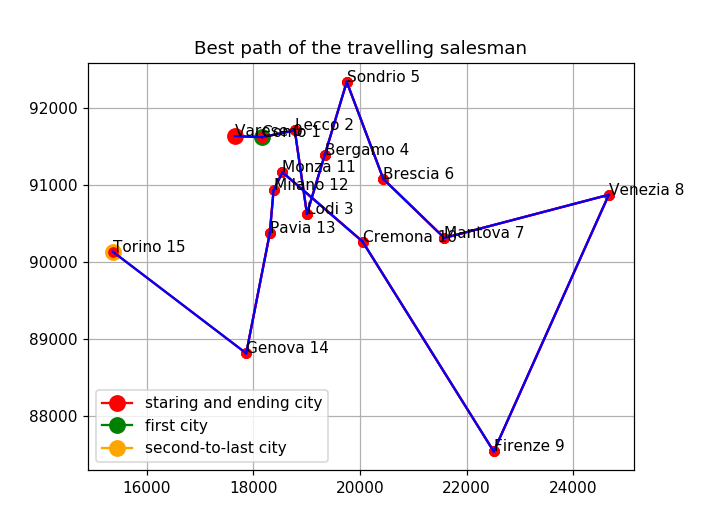

In [12]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.annotate("Varese 0" , (x[0], y[0]))
for i in range(0,len(best_path)):
    txt = cities[int(best_path[i])]
    ax.annotate(txt + " " + str(i+1) , (x[i+1], y[i+1]))
ax.scatter(x,y, marker='.', color='blue', linestyle='--')
ax.plot(x[0],y[0], marker='.', markersize=20, label='staring and ending city', color='red')
ax.plot(x[1],y[1], marker='.', markersize=20, label='first city', color='green')
ax.plot(x[len(x)-2],y[len(y)-2], marker='.', markersize=20, label='second-to-last city', color='orange')
plt.title('Best path of the travelling salesman')
plt.legend(loc = 'lower left')
plt.grid(True)
fig.savefig('ris.pdf')

In [16]:
for i in range(len(best_path)):
    print(i)
    x_p=[x[i],x[i+1]]
    y_p=[y[i],y[i+1]]
    ax.plot(x_p,y_p,'b-')
    x_p=[x[i],x[i+1]]
    y_p=[y[i],y[i+1]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
print(best_path)
print(cities)